### Cechy do klasyfikacji:
- średni sentyment,
- liczba postów z kontrowersyjnym hashtagiem,
- średnia liczba lajków pod postem,
- średnia liczba mentions w poście,
- średnia liczba hashtagów w poście,
- średnia długość posta (liczba znaków),
- replies_count (średnia),
- retweets_count (średnia)
- date_joined,
- num_tweets,
- following,
- followers,
- likes

In [46]:
import pandas as pd
import sklearn
from polyglot.text import Text
from sklearn import metrics, svm, tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tweets = pd.read_csv('file.csv')
tweets = tweets[tweets['hashtags'].str.contains('#listabrakujacychlekow|#listabrakującychleków|#listabrakującychlekow|#listabrakujacychleków')]
tweets.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date'],
      dtype='object')

In [3]:
import pickle

with open('users_info.pkl', 'rb') as f:
    users_info = pickle.load(f)
users_info.columns

Index(['user', 'id', 'fullname', 'date_joined', 'location', 'blog',
       'num_tweets', 'following', 'followers', 'likes', 'lists'],
      dtype='object')

In [4]:
with open('partition.pkl', 'rb') as f:
    partition = pickle.load(f)
    
# Delete communities with less than 5 members
dict_count = {}
for part in partition.values():
    if part not in dict_count:
        dict_count[part] = 0
    dict_count[part] += 1

delete = [key for key in partition if dict_count[partition[key]] < 5] 
for key in delete: del partition[key] 

print("Num communities: ", max(partition.values()) + 1)

Num communities:  4


In [5]:
print("Users: ", len(users_info.values))
print("Tweets: ", len(tweets.values))

Users:  315
Tweets:  817


In [6]:
def get_sentiment(blob):
    text = Text(blob)
    text.language = 'pl'
    return text.polarity

In [8]:
users = pd.DataFrame(columns=['user', 'sentiment_mean', 'num_posts', 'likes_mean', 
                              'mentions_mean', 'hashtags_mean', 
                              'tweet_length_mean', 'replies_mean', 
                              'retweets_mean', 'num_tweets_all', 
                              'num_following', 'num_followers',
                              'num_likes', 'community'])
for user in tweets['username'].unique():
    user_columns = {}
    username = ''
    if type(user) == str:
        username = user.lower()
    if username in partition:
        user_tweets = tweets[tweets.username == username]
        user_info = users_info[users_info.user == user]
        user_columns['user'] = user
        user_columns['sentiment_mean'] = user_tweets['tweet'].apply(get_sentiment).mean()
        user_columns['num_posts'] = len(user_tweets)
        user_columns['likes_mean'] = user_tweets['likes_count'].mean()
        user_columns['mentions_mean'] = user_tweets['mentions'].apply(
            lambda x: len(x.replace("[", '').replace("]", '').split())
        ).mean()
        user_columns['hashtags_mean'] = user_tweets['hashtags'].apply(
            lambda x: len(x.replace("[", '').replace("]", '').split())
        ).mean()
        user_columns['tweet_length_mean'] = user_tweets['tweet'].str.len().mean()
        user_columns['replies_mean'] = user_tweets['replies_count'].mean()
        user_columns['retweets_mean'] = user_tweets['retweets_count'].mean()
        user_columns['num_tweets_all'] = user_info['num_tweets'].sum()
        user_columns['num_following'] = user_info['following'].sum()
        user_columns['num_followers'] = user_info['followers'].sum()
        user_columns['num_likes'] = user_info['likes'].sum()
        user_columns['community'] = partition[username]
        users = users.append(user_columns, ignore_index=True)
users.head()

,user,sentiment_mean,num_posts,likes_mean,mentions_mean,hashtags_mean,tweet_length_mean,replies_mean,retweets_mean,num_tweets_all,num_following,num_followers,num_likes,community
0,ricenola1,-0.200000,5,21.000000,1.200000,1.800000,186.600000,2.000000,5.000000,77171.0,1304.0,4628.0,99295.0,0
1,grzela60,0.037037,54,3.444444,1.888889,1.648148,143.870370,0.351852,0.537037,34663.0,552.0,758.0,30729.0,0
2,martinswidersky,-0.100000,10,11.500000,1.800000,7.700000,253.700000,1.300000,4.200000,0.0,0.0,0.0,0.0,0
3,magdakodds,0.023810,28,6.714286,1.321429,2.857143,198.607143,0.321429,1.214286,34712.0,1932.0,2109.0,95839.0,0
4,_drugie_konto,0.250000,16,1.062500,1.625000,1.312500,123.687500,0.125000,0.062500,11926.0,141.0,180.0,5017.0,0


In [9]:
def split_data(dataset):
    # split into train and test sets
    train_set, test_set = train_test_split(dataset, test_size=0.2, 
                                           random_state=42, stratify=dataset['community'])

    # extract labels
    train_set_labels = train_set["community"].copy()
    train_set = train_set.drop("community", axis=1)

    test_set_labels = test_set["community"].copy()
    test_set = test_set.drop("community", axis=1)

    return train_set, train_set_labels, test_set, test_set_labels

def evaluate(labels_true, labels_predicted):
    accuracy = metrics.accuracy_score(y_true=labels_true, y_pred=labels_predicted)
    precision = metrics.precision_score(y_true=labels_true, y_pred=labels_predicted, average='micro')
    recall = metrics.recall_score(y_true=labels_true, y_pred=labels_predicted, average='micro')
    f1 = metrics.f1_score(y_true=labels_true, y_pred=labels_predicted, average='micro')

    return accuracy, precision, recall, f1

In [50]:
users_noname = users.drop('user', axis=1)
x_train, y_train, x_test, y_test = split_data(users_noname)
# clf = GaussianNB()  # 0.322
# clf = svm.SVC(gamma='scale', decision_function_shape='ovo')  # 0.435
# clf = KNeighborsClassifier(n_neighbors=5)  # 0.516
# clf = tree.DecisionTreeClassifier()  # 0.5
# clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
#     max_depth=1, random_state=0)  # 0.483
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,
    random_state=0)  # 0.516
# clf = sklearn.ensemble.RandomForestClassifier()  # 0.403
# clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
#                     hidden_layer_sizes=(5, 2), random_state=1)  # 0.322
y_train = y_train.astype('int')
y_test = y_test.astype('int')
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy, precision, recall, f1 = evaluate(y_test.values.tolist(), y_pred)
print(accuracy, precision, recall, f1)


0.5161290322580645 0.5161290322580645 0.5161290322580645 0.5161290322580645


In [51]:
def plot_confusion_matrix(y_test, y_pred):
    conf_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
    conf_matrix = np.around(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

    fig, ax = plt.subplots(figsize=(8,8))   
    ax = sns.heatmap(conf_matrix, cmap="PiYG", annot=True, center=0)
   

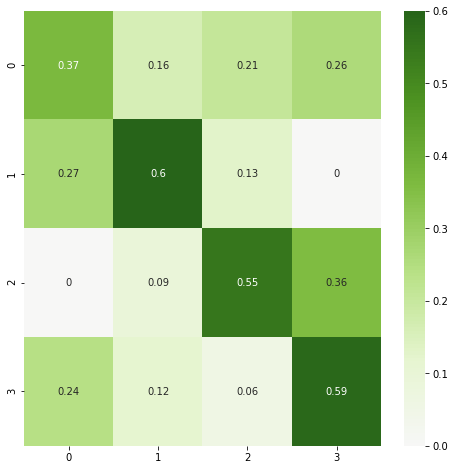

In [52]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred)

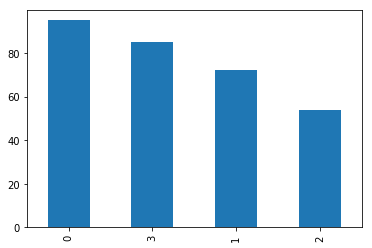

In [53]:
users['community'].value_counts().plot(kind='bar')

In [54]:
users[users.user == 'kobywatelska'][['user', 'community']]

,user,community
246,kobywatelska,3
